## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

/home/suhail/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
/home/suhail/snap/jupyter/common/lib/python3.7/site-packages/numba/npyufunc/parallel.py:243: UserWarning: Could not obtain multiprocessing lock due to OS level error: [Errno 13] Permission denied
A likely cause of this problem is '/dev/shm' is missing orread-only such that necessary semaphores cannot be written.
*** The responsibility of ensuring multiprocessing safe access to this initialization sequence/module import is deferred to the user! ***

  warnings.warn(msg % str(e))
Using TensorFlow backend.


In [2]:
from keras import regularizers

In [3]:
import os

In [4]:
mylist= os.listdir('RawData/')

In [5]:
type(mylist)

list

In [6]:
print(mylist[1800])

f01 (10).wav


In [7]:
print(mylist[400][6:-16])

03


## Plotting the audio file's waveform and its spectrogram

In [8]:
data, sampling_rate = librosa.load('RawData/f11 (2).wav')

Populating the interactive namespace from numpy and matplotlib


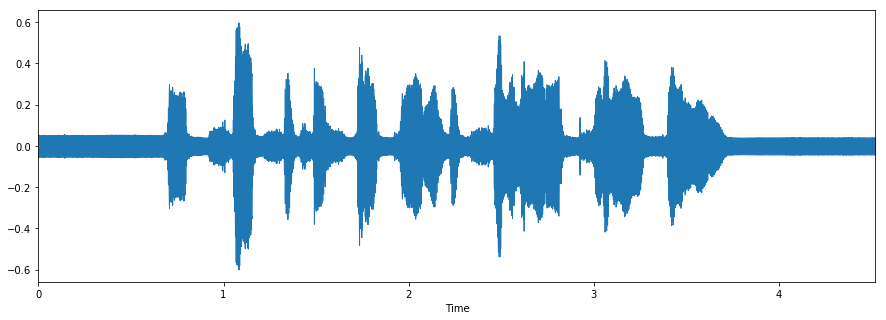

In [9]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

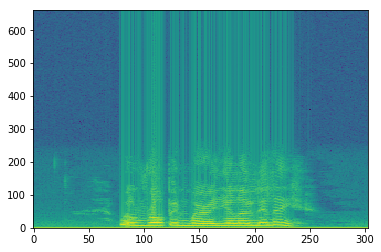

In [10]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/f10 (2).wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [11]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')

In [12]:
labels = pd.DataFrame(feeling_list)

In [13]:
labels[:10]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [14]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [15]:
df[:5]

,feature
0,"[-70.2677641611, -70.2677641611, -70.267764161..."
1,"[-65.7076524007, -65.7076524007, -63.114722422..."
2,"[-65.4824988827, -65.4824988827, -65.482498882..."
3,"[-64.5284491035, -64.5284491035, -64.528449103..."
4,"[-62.3643105275, -59.9347251381, -61.869599961..."


In [16]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [17]:
newdf = pd.concat([df3,labels], axis=1)

In [18]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [19]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,...,-57.447461,-58.896493,-58.751002,-57.405669,-60.078475,-63.426811,-62.638537,-61.116223,-60.357015,male_calm
1,-65.707652,-65.707652,-63.114722,-61.518999,-61.097138,-63.424602,-63.720067,-56.854608,-55.168972,-54.640002,...,-39.792147,-40.613166,-41.209201,-41.439204,-43.994282,-49.399616,-50.591601,-49.146184,-48.687893,female_calm
2,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,...,-31.346553,-34.310774,-35.800705,-35.936112,-37.631846,-40.119408,-41.662903,-41.333382,-40.721261,male_calm
3,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-65.928222,...,-48.674306,-48.596082,-47.602751,-43.049195,-42.659546,-43.188561,-44.001237,-43.512184,-43.644038,female_calm
4,-62.364311,-59.934725,-61.869600,-67.495764,-71.071811,-65.679826,-63.394396,-65.503349,-61.856639,-60.005421,...,-39.071328,-41.897121,-40.865430,-38.290605,-36.372397,-37.915779,-40.026125,-43.386896,-44.065982,male_calm


In [20]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
1130,-21.316034,-21.405165,-23.427492,-22.760799,-23.077980,-22.940379,-22.521370,-22.318232,-23.623762,-22.484483,...,-30.090434,-25.397213,-24.566368,-25.313775,-27.188736,-27.189815,-26.741160,-24.144054,-21.752971,male_angry
1611,-28.023489,-27.012539,-24.843077,-26.073845,-26.605960,-25.415706,-26.137463,-25.882579,-26.144014,-25.486000,...,-9.060266,-10.795528,-11.224794,-10.564187,-10.653920,-10.423875,-10.612708,-9.730200,-6.192753,male_sad
606,-47.580376,-47.580376,-47.580376,-47.580376,-47.580376,-47.580376,-47.580376,-47.580376,-47.580376,-47.580376,...,-17.349710,-17.208624,-17.796563,-17.936725,-17.350310,-17.991303,-18.088496,-19.591927,-19.046431,male_angry
1356,-24.687263,-23.900377,-22.685773,-23.947191,-25.353984,-25.198551,-26.250432,-26.599865,-27.327227,-26.959255,...,-2.508218,-2.625317,-3.431428,-5.119769,-7.367091,-8.972608,-10.649444,-14.163026,-18.706701,male_happy
535,-59.254190,-55.769097,-53.499152,-53.206541,-51.857334,-51.743066,-53.126957,-53.163642,-53.088024,-54.972413,...,-52.252787,-50.024027,-50.142246,-50.522777,-51.571928,-50.673416,-51.651291,-52.595671,-50.934325,female_sad
1397,-13.596653,-17.466871,-26.128334,-27.447346,-28.217343,-28.169207,-28.163326,-29.641523,-30.600591,-31.308342,...,-39.573127,-38.788175,-38.404735,-41.522524,NaN,NaN,NaN,NaN,NaN,male_happy
813,-57.705173,-57.728170,-56.672727,-56.152195,-57.413794,-58.473491,-58.040922,-57.550879,-58.224060,-56.276742,...,-52.148175,-52.575092,-52.733973,-53.780274,-54.433161,-57.540984,-57.138044,-55.263390,-54.655835,female_fearful
1538,-29.934310,-31.293358,-32.880679,-34.448076,-35.698980,-38.608411,-40.439090,-40.267872,-41.617890,-44.013965,...,-43.273342,-37.321326,-30.551111,-27.834584,-26.978020,-27.281610,-27.756957,-25.164714,-19.921744,male_sad
111,-62.748082,-62.748239,-62.759160,-62.761158,-62.758553,-62.763573,-62.760713,-62.748239,-62.748239,-62.774872,...,-39.684156,-43.283529,-44.693196,-42.968453,-41.411920,-44.474100,-46.436648,-44.232114,-41.150455,female_calm
1042,-25.975306,-22.825102,-21.225165,-20.821093,-19.913892,-20.578139,-22.024481,-20.963704,-14.915607,-11.356564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_angry


In [21]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [22]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [23]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
384,-66.348220,-66.348220,-66.348220,-66.348220,-66.348220,-62.797142,-65.721075,-66.348220,-66.348220,-66.348220,...,-52.630403,-49.383379,-49.429265,-52.419689,-53.660921,-53.482833,-52.205515,-53.841911,-54.661535,male_sad
595,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,-66.730016,...,-66.730016,-66.730016,-66.659748,-66.092053,-66.427894,-66.730016,-66.561697,-65.294555,-65.872494,female_angry
419,-53.769216,-55.061158,-53.305227,-51.120282,-52.921001,-52.180352,-53.490261,-54.648841,-52.985473,-51.930319,...,-48.560605,-47.684605,-46.392758,-47.169001,-48.063584,-49.027493,-50.796035,-50.996393,-49.011706,female_sad
1318,0.141154,-1.890112,-6.834041,-7.146915,-7.428035,-7.331070,-7.330199,-7.143712,-7.353791,-7.521930,...,-21.726595,-21.101817,-20.511847,-19.783785,-22.081602,-21.137747,-19.667655,-20.545305,-22.456955,male_fearful
680,-43.826744,-44.310900,-44.328308,-44.203774,-44.118380,-44.075670,-43.239178,-43.239971,-43.038306,-42.939907,...,-20.941555,-25.617258,-26.698866,-25.630834,-28.005305,-30.681028,-32.177225,-31.636646,-30.872800,male_angry
1344,-28.520928,-26.120322,-26.568178,-26.995864,-26.450248,-26.345966,-26.882970,-25.830752,-26.015952,-27.689731,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,male_happy
723,-43.612680,-43.612680,-43.612680,-43.612680,-43.612680,-43.612680,-43.612680,-43.612680,-43.612680,-43.612680,...,-42.085371,-42.376162,-43.340164,-42.947368,-43.227011,-43.231191,-44.128215,-43.663723,-42.887394,female_angry
1265,-39.991394,-35.741445,-28.598387,-26.013478,-26.699656,-23.846577,-22.048639,-22.696152,-24.532903,-30.425296,...,-42.750622,-42.401878,-42.229751,-41.913388,-40.750282,-39.964052,-40.102125,-38.991461,-36.121244,male_fearful
607,-46.424902,-46.442376,-47.522544,-47.161764,-47.574394,-49.036715,-49.656684,-50.018894,-49.297414,-48.125211,...,-47.007094,-47.213200,-46.885091,-47.983125,-50.044078,-48.948539,-47.469149,-47.738534,-46.882835,female_angry
543,-59.961592,-57.833689,-59.973265,-61.480152,-61.480152,-61.480152,-61.480152,-61.480152,-60.477495,-57.440553,...,-42.841297,-46.036947,-47.290371,-48.049756,-52.795936,-51.500848,-49.947344,-51.618375,-53.168421,female_sad


In [24]:
trainfeatures = train.iloc[:, :-1]

In [25]:
trainlabel = train.iloc[:, -1:]

In [26]:
testfeatures = test.iloc[:, :-1]

In [27]:
testlabel = test.iloc[:, -1:]

In [28]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [30]:
X_train.shape

(1378, 216)

## Changing dimension for CNN model

In [31]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [45]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 216, 256)          1536      
_________________________________________________________________
activation_11 (Activation)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 216, 128)          163968    
_________________________________________________________________
activation_12 (Activation)   (None, 216, 128)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 27, 128)           82048     
__________

In [47]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

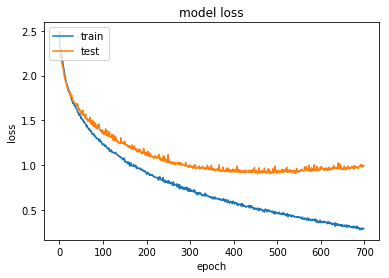

In [37]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [112]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\mites\Documents\Cognitive\Final Exam\saved_models\Emotion_Voice_Detection_Model.h5 


In [1]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

NameError: name 'model' is not defined

## Loading the model

In [2]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

W0713 05:11:59.784190 140159546140480 deprecation_wrapper.py:119] From /home/suhail/snap/jupyter/common/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0713 05:11:59.990734 140159546140480 deprecation_wrapper.py:119] From /home/suhail/snap/jupyter/common/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0713 05:12:00.014931 140159546140480 deprecation_wrapper.py:119] From /home/suhail/snap/jupyter/common/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0713 05:12:00.130849 140159546140480 deprecation_wrapper.py:119] From /home/suhail/snap/jupyter/common/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is depre

Loaded model from disk


NameError: name 'opt' is not defined

## Predicting emotions on the test data

In [138]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

319/319 [==============================] - 0s     


In [139]:
preds

array([[  3.49815641e-12,   1.18043589e-10,   1.13181663e-19, ...,
          1.80016723e-05,   7.36836637e-06,   1.14132257e-04],
       [  3.87504338e-16,   5.73074694e-23,   1.31673211e-14, ...,
          1.75147681e-04,   1.85760673e-05,   9.99805748e-01],
       [  8.39285008e-07,   3.43896300e-11,   5.38965035e-03, ...,
          9.93317604e-01,   1.99900052e-04,   1.05243188e-03],
       ..., 
       [  3.49616457e-04,   1.94651744e-04,   6.65218568e-06, ...,
          1.67340226e-02,   6.44345134e-02,   9.10043001e-01],
       [  4.23396705e-06,   1.59581254e-11,   6.03030126e-12, ...,
          6.36715861e-03,   9.64888096e-01,   2.34207995e-02],
       [  3.69524572e-31,   0.00000000e+00,   0.00000000e+00, ...,
          5.24333927e-07,   9.99998808e-01,   6.36476927e-10]], dtype=float32)

In [115]:
preds1=preds.argmax(axis=1)

In [116]:
preds1

array([6, 9, 7, 1, 7, 8, 1, 2, 5, 8, 7, 1, 9, 9, 4, 0, 5, 0, 5, 8, 4, 1, 5,
       9, 7, 5, 7, 1, 7, 5, 8, 1, 8, 9, 2, 2, 1, 8, 6, 0, 5, 9, 1, 0, 7, 5,
       5, 7, 7, 0, 0, 7, 0, 0, 6, 5, 3, 7, 5, 8, 5, 4, 8, 8, 9, 7, 2, 8, 6,
       1, 5, 6, 8, 6, 5, 3, 4, 8, 8, 9, 9, 0, 8, 9, 4, 5, 0, 0, 5, 5, 7, 9,
       4, 7, 8, 6, 9, 5, 6, 8, 1, 7, 0, 8, 8, 7, 3, 2, 7, 8, 7, 9, 7, 9, 5,
       7, 8, 6, 0, 1, 6, 9, 1, 5, 8, 7, 1, 8, 6, 9, 3, 7, 7, 4, 6, 5, 8, 8,
       1, 0, 5, 0, 7, 6, 5, 7, 4, 9, 2, 5, 4, 7, 5, 6, 8, 5, 5, 4, 8, 8, 2,
       7, 5, 7, 6, 9, 8, 9, 9, 0, 2, 5, 7, 8, 3, 0, 4, 6, 6, 9, 9, 9, 3, 8,
       1, 7, 2, 5, 8, 1, 8, 4, 4, 8, 5, 2, 9, 9, 5, 6, 0, 5, 9, 0, 8, 7, 4,
       6, 6, 3, 9, 5, 9, 6, 1, 7, 5, 7, 8, 4, 9, 2, 5, 6, 6, 4, 2, 1, 8, 2,
       7, 5, 7, 3, 5, 6, 8, 7, 1, 6, 0, 0, 4, 7, 4, 4, 4, 4, 4, 0, 8, 1, 6,
       7, 4, 8, 7, 8, 2, 9, 6, 2, 7, 8, 3, 9, 9, 7, 2, 5, 7, 2, 9, 5, 5, 7,
       8, 5, 6, 8, 1, 2, 5, 9, 4, 5, 5, 6, 7, 8, 7, 0, 9, 5, 9, 5, 9, 7, 8,
       1, 2,

In [117]:
abc = preds1.astype(int).flatten()

In [118]:
predictions = (lb.inverse_transform((abc)))

In [119]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_calm
1,male_sad
2,male_fearful
3,female_calm
4,male_fearful
5,male_happy
6,female_calm
7,female_fearful
8,male_angry
9,male_happy


In [120]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [121]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_calm
1,male_sad
2,male_fearful
3,female_fearful
4,male_fearful
5,male_happy
6,female_calm
7,female_angry
8,male_angry
9,male_happy


In [122]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [128]:
finaldf[170:180]

,actualvalues,predictedvalues
170,female_fearful,female_fearful
171,male_angry,male_angry
172,male_fearful,male_fearful
173,male_happy,male_happy
174,female_happy,female_happy
175,female_angry,female_angry
176,female_angry,female_sad
177,male_sad,male_calm
178,male_angry,male_calm
179,male_sad,male_sad


In [129]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,21
female_calm,20
female_fearful,19
female_happy,17
female_sad,20
male_angry,55
male_calm,25
male_fearful,55
male_happy,49


In [130]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,25
female_calm,22
female_fearful,19
female_happy,9
female_sad,25
male_angry,51
male_calm,29
male_fearful,51
male_happy,50


In [131]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [19]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pickle

file=open('lbsave.txt','rb')
lb = pickle.load(file)

/home/suhail/snap/jupyter/common/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [20]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")

Loaded model from disk


In [21]:
import librosa
data, sampling_rate = librosa.load('hUY8DiQgUUg-0-30_2019-06-22_224559.797771.wav')

Populating the interactive namespace from numpy and matplotlib


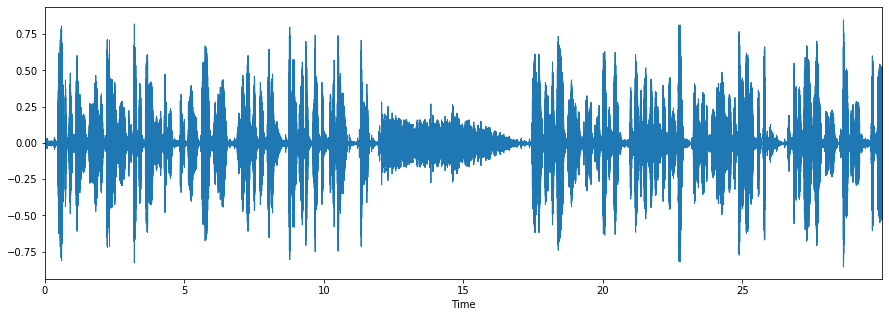

In [34]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [23]:
import IPython.display as ipd
ipd.Audio('hUY8DiQgUUg-0-30_2019-06-22_224559.797771.wav')

In [24]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('hUY8DiQgUUg-0-30_2019-06-22_224559.797771.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [25]:
livedf2= pd.DataFrame(data=livedf2)

In [26]:
livedf2 = livedf2.stack().to_frame().T

In [27]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-4.736008,-6.460601,-13.095533,-13.192662,-14.267134,-15.049237,-16.826032,-17.369135,-19.919927,-18.687121,...,-15.292188,-15.881504,-15.873259,-17.023482,-19.475604,-19.213201,-18.007329,-14.46384,-4.429441,0.966365


In [28]:
twodim= np.expand_dims(livedf2, axis=2)

In [29]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 81ms/step


In [30]:
livepreds

array([[1.3057220e-15, 1.2266101e-26, 3.7897970e-21, 4.0825186e-14,
        2.7458581e-19, 4.0403271e-01, 1.9375336e-10, 1.0814615e-01,
        4.8778611e-01, 3.4921391e-05]], dtype=float32)

In [31]:
livepreds1=livepreds.argmax(axis=1)

In [32]:
liveabc = livepreds1.astype(int).flatten()

In [33]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions



array(['male_happy'], dtype=object)